# Seasonalities and Holidays
Despite that time-series modeling is not super feature-rich, we can still leverage at least deterministic features which are known in advance - calendar patterns. 

The easiest way how to model seasonality and leverage the power of ML models is to create a binary feature for each repeating calendar pattern (day of the week, the month of the year...). This is implemented in the 
SeasonalityTransformer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
from hcrystalball.utils import get_sales_data

df = get_sales_data(n_dates=365*2, 
                    n_assortments=1, 
                    n_states=1, 
                    n_stores=1)
X, y = pd.DataFrame(index=df.index), df['Sales']

## Seasonality Features

In [3]:
from hcrystalball.feature_extraction import SeasonalityTransformer
SeasonalityTransformer(freq = 'D').fit(X, y).transform(X).head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1_week,2_week,3_week,...,November,October,September,1_quarter,2_quarter,3_quarter,4_quarter,2013,2014,2015
Date,,,,,,,,,,,,,,,,,,,,,
2013-08-01,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2013-08-02,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2013-08-03,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2013-08-04,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2013-08-05,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


## Holiday Features

One of the important parts of time-series modeling is taking into account holidays which in most cases exhibit different behavior than it's common. hcrystalball implements HolidayTransformer which returns column with string name of the holiday based on provided country ISO code for each date in the dataset (empty string if it's not a holiday). All hcrystalball wrappers accept the output of HolidayTransformer and transform it into individual model formats. HolidayTransformer also supports some region specific holidays i.e. Germany state specific holidays, in that case the provided string shoule be in form country-region: i.e. 'DE-HE'.

In [4]:
from hcrystalball.feature_extraction import HolidayTransformer
HolidayTransformer(country_code = 'DE').fit(X, y).transform(X)['2013-12-22':'2014-01-01']

,holiday
Date,
2013-12-22,
2013-12-23,
2013-12-24,
2013-12-25,Christmas Day
2013-12-26,Second Christmas Day
2013-12-27,
2013-12-28,
2013-12-29,
2013-12-30,


## In Pipelines

In [5]:
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.wrappers import ExponentialSmoothingWrapper
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [6]:
pipeline = Pipeline([
    ('holidays', HolidayTransformer(country_code = 'DE')),
    ('seasonality', SeasonalityTransformer(freq='D')),
    ('model', get_sklearn_wrapper(RandomForestRegressor))
]) 

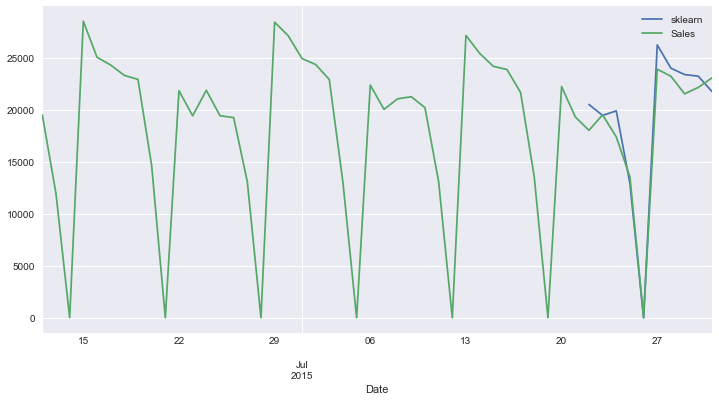

In [7]:
(pipeline.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
         .plot()
);

### Also country code column can be used. 
*Note: This column is deleted in `HolidayTransformer.transform` method to not pollute further processing*

In [8]:
pipeline_col = Pipeline([
    ('holidays', HolidayTransformer(country_code_column = 'country')),
    ('seasonality', SeasonalityTransformer(freq='D')),
    ('model', get_sklearn_wrapper(RandomForestRegressor))
]) 

In [9]:
X_col = X.copy().assign(country='DE')

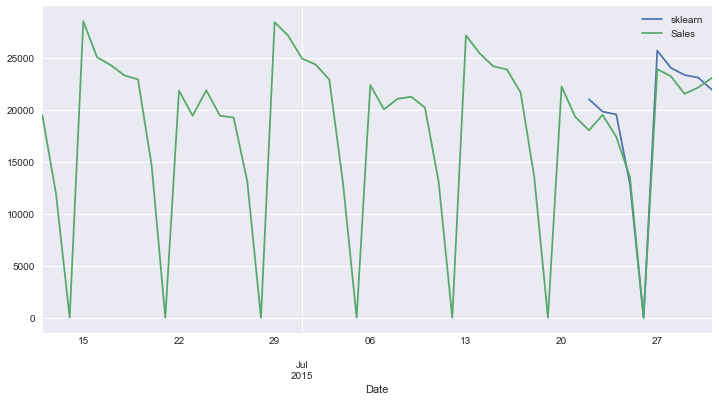

In [10]:
(pipeline_col.fit(X_col[:-10], y[:-10])
         .predict(X_col[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
         .plot()
);

## With exogenous variables

In [11]:
X_col['trend'] = np.arange(len(X))

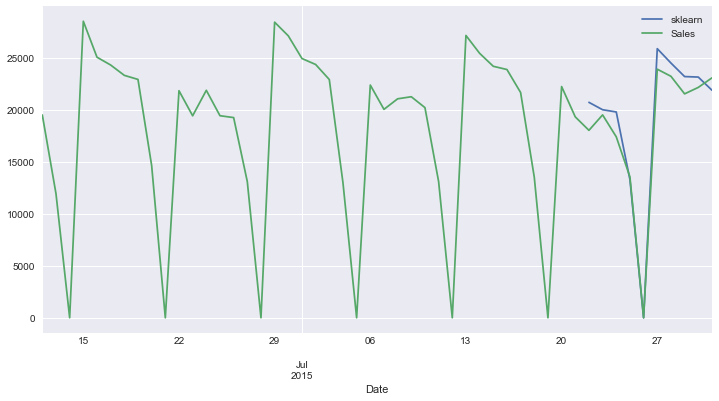

In [12]:
(pipeline_col.fit(X_col[:-10], y[:-10])
         .predict(X_col[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
         .plot()
);